In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision                             # to access MNIST dataset
import torchvision.transforms as transforms

In [2]:
torch.manual_seed(111)

In [3]:
# set up environment to use GPU if available
# if run on CPU, will take ~100 min (2min/epoch * 50 epochs)
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
# Prepare Training Data
# MNIST consists of 28x28 pixel grayscale images of handwritten digits from 0 to 9
# transforms.ToTensor() to convert data to PyTorch tensor
# transforms.Normalize() to convert range of tensor coefficients from [0,1] to [-1,1] by subtracting 0.5 and dividing by 0.5.
#   Range [0,1] shows most of image as 0 because image backgrounds are black
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]    # note: grayscale has only one channel so tuples fed to .Normalize() have only one value
)

In [5]:
# load training data
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform             # MNIST dataset will be downloaded
)

100.1%

Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw


113.5%

Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw


100.4%

Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw


180.4%

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw
Processing...
Done!


In [6]:
# create data loader
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

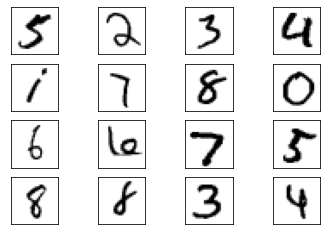

In [7]:
# plot some samples of training data
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")          # cmap=gray_r to reverse color scheme to improve visual
    plt.xticks([])
    plt.yticks([])

In [8]:
# Implement the Discriminator and Generator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 784)         # vectorize images so MLP neural network receives vectors with 784 coefficients (32x1x28x28 --> 32x784)
        output = self.model(x)
        return output

In [9]:
discriminator = Discriminator().to(device=device)    # instantiate discriminator to use GPU if available

In [10]:
# increase dimensions of input from latent space to allow generator to generate more complex data
# 100-dimensional input, output with 784 coefficients organized in 28x28 tensor representing an image
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),                  # hyperbolic tangent function as activation of output layer because output coefficients in range [-1, 1]
        )
    
    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [11]:
# Train the Models
# training parameters
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [12]:
# training loop
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        
        # data for discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        # train the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        # data for generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        
        # train the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()
        
        # display loss
        if n == batch_size-1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5412760972976685
Epoch: 0 Loss G.: 0.5153388381004333
Epoch: 1 Loss D.: 0.04715801402926445
Epoch: 1 Loss G.: 6.1392436027526855
Epoch: 2 Loss D.: 0.03100760467350483
Epoch: 2 Loss G.: 3.846494674682617
Epoch: 3 Loss D.: 0.004632871598005295
Epoch: 3 Loss G.: 5.032060146331787
Epoch: 4 Loss D.: 0.01590071991086006
Epoch: 4 Loss G.: 4.969620227813721
Epoch: 5 Loss D.: 0.052896175533533096
Epoch: 5 Loss G.: 5.569124221801758
Epoch: 6 Loss D.: 0.03173278644680977
Epoch: 6 Loss G.: 4.529135227203369
Epoch: 7 Loss D.: 0.0761520266532898
Epoch: 7 Loss G.: 3.055007219314575
Epoch: 8 Loss D.: 0.1207982525229454
Epoch: 8 Loss G.: 2.8473198413848877
Epoch: 9 Loss D.: 0.16616320610046387
Epoch: 9 Loss G.: 3.1525392532348633
Epoch: 10 Loss D.: 0.12946158647537231
Epoch: 10 Loss G.: 3.176778554916382
Epoch: 11 Loss D.: 0.2064095437526703
Epoch: 11 Loss G.: 2.3618128299713135
Epoch: 12 Loss D.: 0.3043888509273529
Epoch: 12 Loss G.: 2.473623037338257
Epoch: 13 Loss D.: 0.166892662

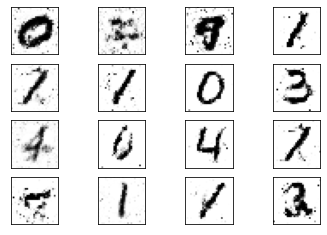

In [13]:
# generate handwritten digits
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.cpu().detach()    # need to send data to CPU for plotting
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])